In [2]:
import numpy as np
import kagglehub
import os
from collections import defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import seaborn as sns
import struct

In [3]:
if not os.path.exists("/content/data"):
  !kaggle datasets download -d hojjatk/mnist-dataset -p /content
  !unzip /content/mnist-dataset.zip -d /content/data
  !rm /content/mnist-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 41% 9.00M/22.0M [00:00<00:00, 68.2MB/s]
100% 22.0M/22.0M [00:00<00:00, 108MB/s] 
Archive:  /content/mnist-dataset.zip
  inflating: /content/data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: /content/data/t10k-images.idx3-ubyte  
  inflating: /content/data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: /content/data/t10k-labels.idx1-ubyte  
  inflating: /content/data/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: /content/data/train-images.idx3-ubyte  
  inflating: /content/data/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: /content/data/train-labels.idx1-ubyte  


In [4]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Assuming the file is in the /content/mnist-dataset directory
images = read_idx('/content/data/train-images-idx3-ubyte/train-images-idx3-ubyte')
labels = read_idx('/content/data/train-labels-idx1-ubyte/train-labels-idx1-ubyte')

print(images.shape)  # Print the shape of the image data
print(labels.shape)  # Print the shape of the label datan

(60000, 28, 28)
(60000,)


In [ ]:
num_pixels = 28 * 28  # Total number of pixels in MNIST images
num_images = images.shape[0]
pixelThreshold = 100

# Find all pixel indices where value > pixelThreshold
image_idx, row_idx, col_idx = np.where(images > pixelThreshold)

# Convert (row, col) to a 1D pixel index
pixel_nums = row_idx * 28 + col_idx

# Create a sparse binary activation matrix
# shape = 28*28 pixels for each image
# initialize with 1 for where pixels are above threshold
# np.ones(len(image_idx)) - make an array of 1 for each pixel above threshold
# place 1s from ^ in these row,col indices (image_idx, pixel_nums)
activation_matrix = csr_matrix(
    (np.ones(len(image_idx), dtype=np.uint16), (image_idx, pixel_nums)),
    shape=(num_images, num_pixels)
)

assert np.all((activation_matrix.data == 0) | (activation_matrix.data == 1)), "Matrix contains invalid values!"

# matrix of numPixels by numPixels - shows how often pixel i was activated with pixel j
co_occurrence_matrix = activation_matrix.T @ activation_matrix
co_occurrence_matrix = co_occurrence_matrix.astype(np.uint16)

# Convert to CSR format for efficient lookups
co_occurrence_matrix = co_occurrence_matrix.tocsr()

Hypothesis: I would expect that in a co-occurrence matrix for ALL images - the highest co-occurring pixels would be those around the center? since most numbers seem to go towards the center?

Result: Yes center is common but the top center and bottom center seem to have the highest concentration of pixels commonly occuring with other pixels

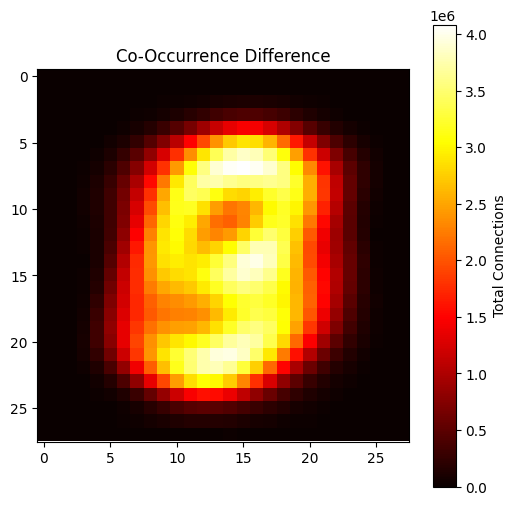

In [ ]:
def plot_heatmap(matrix, title="Co-Occurrence Difference"):
    # Calculate the total number of connections for each pixel
    pixel_connections = matrix.sum(axis=1)
    # Convert 1D pixel scores to a 28x28 image
    connection_heatmap = pixel_connections.reshape(28, 28)

    # Plot the heatmap
    plt.figure(figsize=(6,6))
    plt.imshow(connection_heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar(label="Total Connections")
    plt.title(title)
    plt.show()

plot_heatmap(co_occurrence_matrix)

In [ ]:
# Get unique labels
unique_labels = np.unique(labels)

# Dictionary to store co-occurrence matrices for each label
label_co_occurrence_matrices = {}

# Compute co-occurrence matrix for each label separately
for label in unique_labels:
    # Select images that belong to this label
    label_indices = np.where(labels == label)[0]

    # Subset activation matrix for these images only
    label_activation_matrix = activation_matrix[label_indices]

    # Compute co-occurrence matrix for this label
    label_co_occurrence_matrix = label_activation_matrix.T @ label_activation_matrix
    label_co_occurrence_matrix = label_co_occurrence_matrix.astype(np.uint16).tocsr().toarray()

    # Store in dictionary
    label_co_occurrence_matrices[label] = label_co_occurrence_matrix

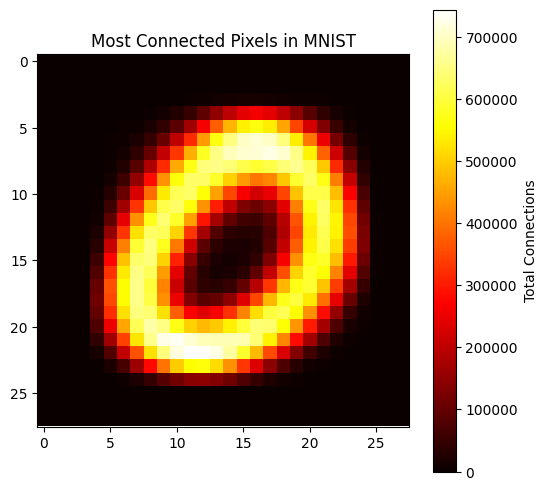

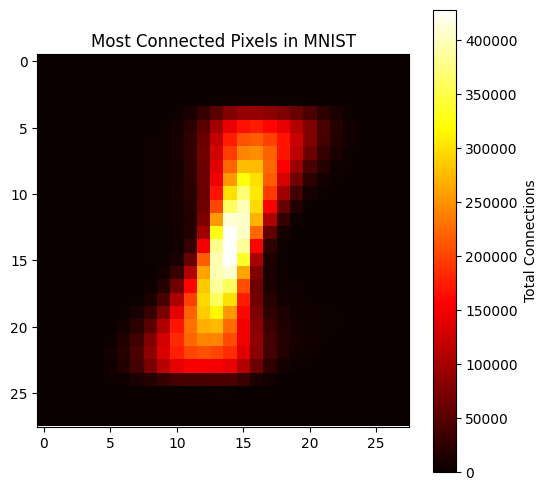

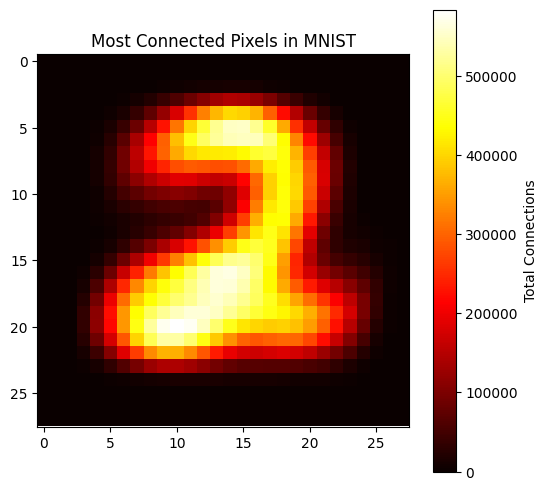

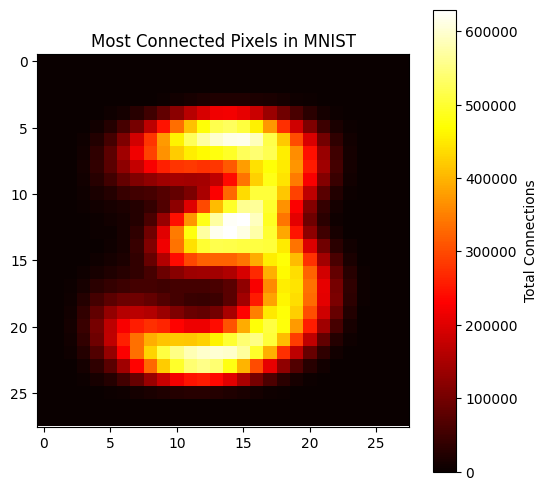

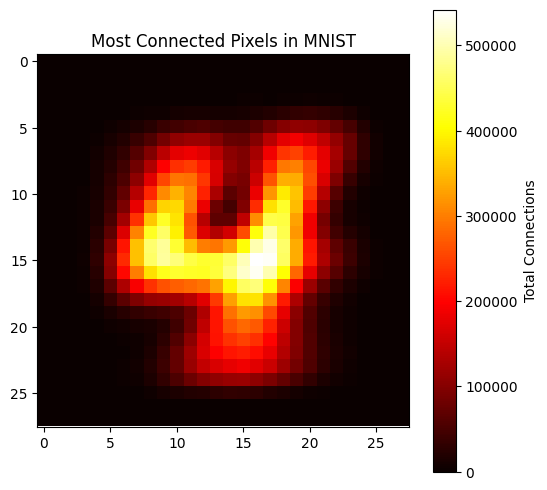

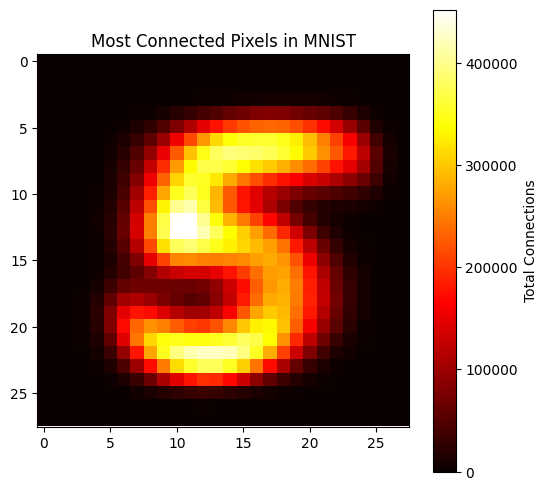

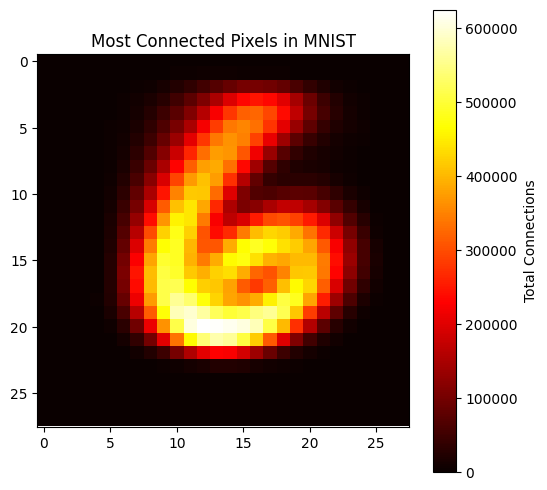

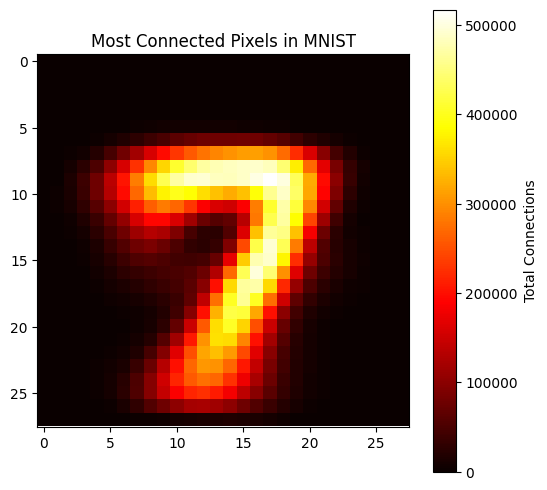

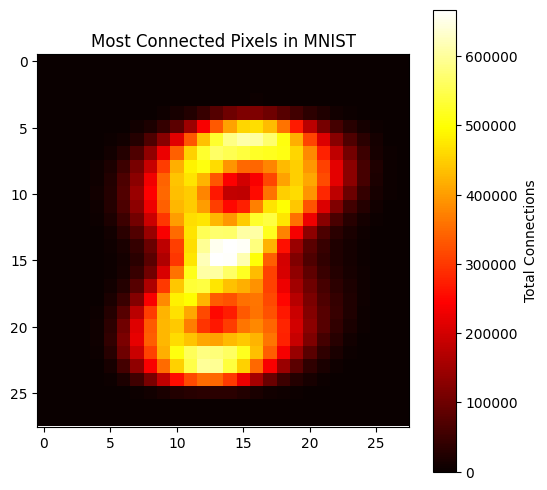

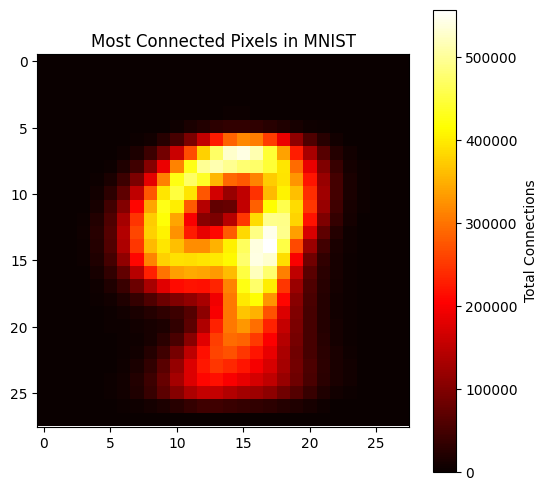

In [ ]:
for k,v in label_co_occurrence_matrices.items():
    plot_heatmap(v)

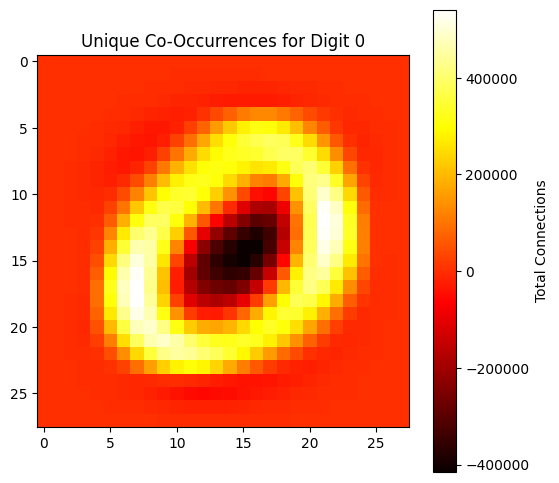

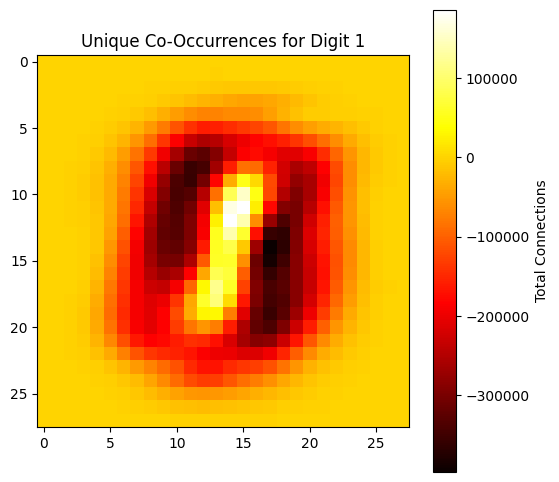

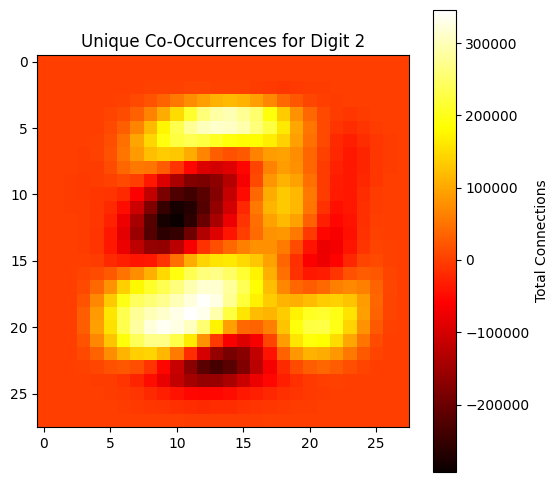

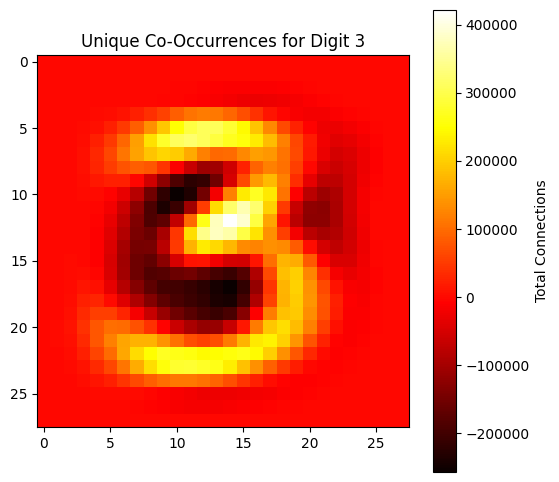

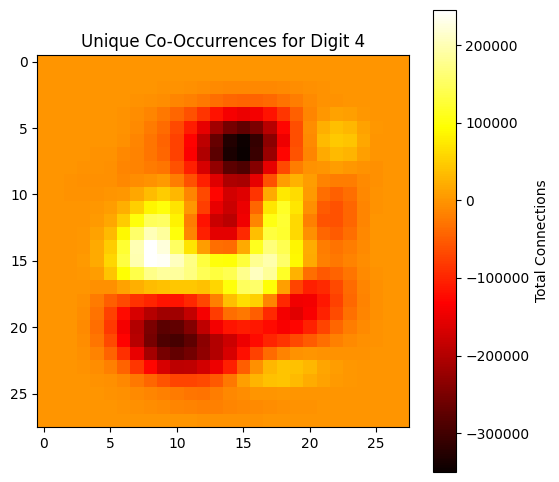

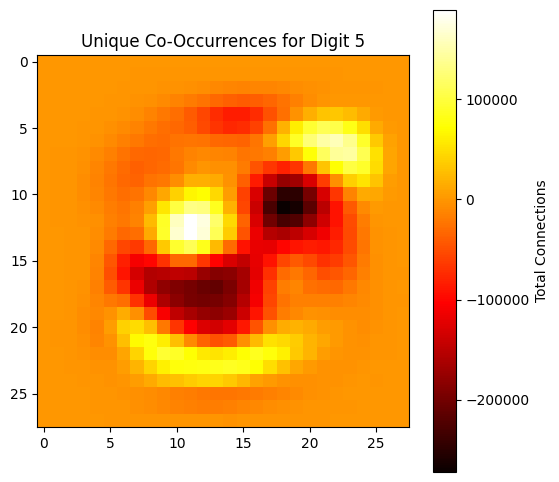

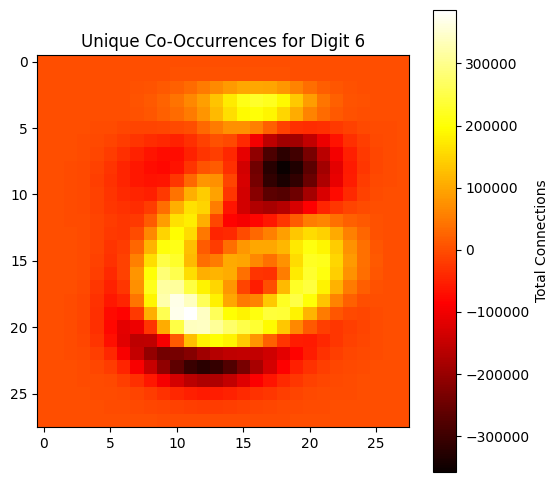

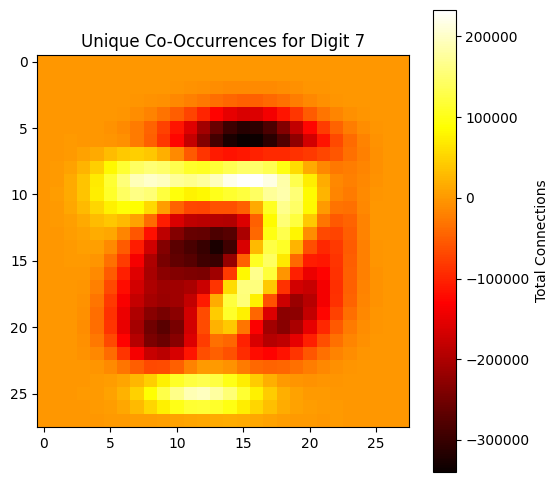

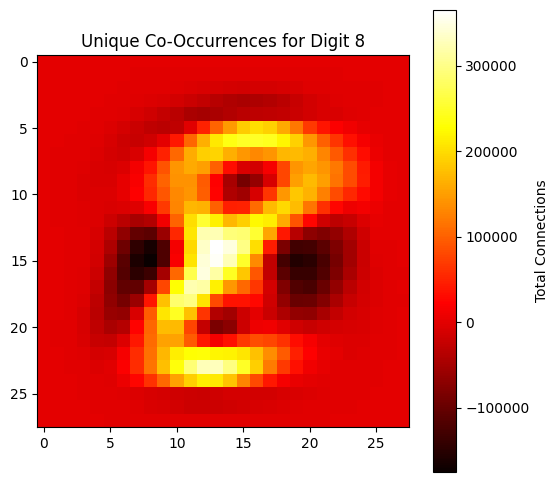

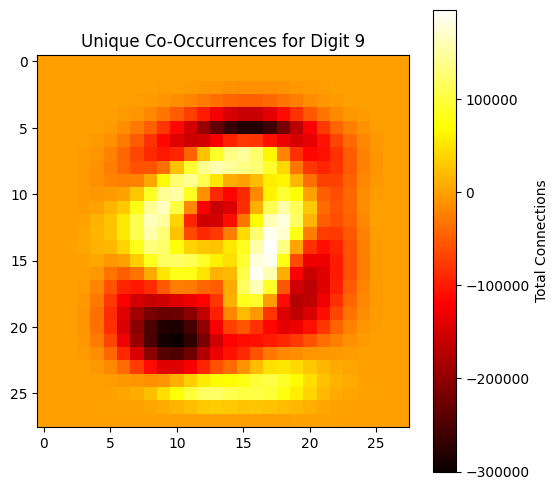

In [ ]:
# Compute the "uniqueness" of each co-occurrence matrix
unique_co_occurrences = {}

for k1, v1 in label_co_occurrence_matrices.items():
    # Compute the average co-occurrence matrix of all other digits
    avg_other_matrices = np.mean([v2 for k2, v2 in label_co_occurrence_matrices.items() if k2 != k1], axis=0)

    # Compute the difference between this digit and the average of all others
    unique_matrix = v1 - avg_other_matrices

    # Store result
    unique_co_occurrences[k1] = csr_matrix(unique_matrix)  # Keep as sparse matrix to save memory

    # Plot heatmap of unique co-occurrences
    plot_heatmap(unique_matrix, title=f"Unique Co-Occurrences for Digit {k1}")

In [ ]:
matrix = np.zeros((10, 10), dtype=int)

# Draw a "0" shape (hollow circle) using 1s
matrix[2:8, 2] = 1   # Left vertical line
matrix[2:8, 7] = 1   # Right vertical line
matrix[2, 3:7] = 1   # Top horizontal line
matrix[7, 3:7] = 1   # Bottom horizontal line

matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
def generate_zero_shape_matrix(size=10, top_left=(2, 2), height=6, width=6):
    """
    Generates a matrix with a '0' shape inside it, where:

    - size: The size of the square matrix (size x size).
    - top_left: The (row, col) position of the top-left corner of the '0' shape.
    - height: The height of the '0' shape.
    - width: The width of the '0' shape.

    Returns:
    - A numpy array representing the matrix with the '0' shape.
    """
    # Initialize matrix with zeros
    matrix = np.zeros((size, size), dtype=int)

    # Extract starting row and column
    r, c = top_left

    # Ensure the '0' shape fits within the matrix bounds
    if r + height > size or c + width > size:
        raise ValueError("The 0 shape does not fit within the matrix boundaries.")

    # Draw the left and right vertical bars
    matrix[r:r + height, c] = 1   # Left vertical line
    matrix[r:r + height, c + width - 1] = 1  # Right vertical line

    # Draw the top and bottom horizontal bars
    matrix[r, c + 1:c + width - 1] = 1   # Top horizontal line
    matrix[r + height - 1, c + 1:c + width - 1] = 1  # Bottom horizontal line

    return matrix

generate_zero_shape_matrix(size=15, top_left=(2,5), height=10, width=6)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

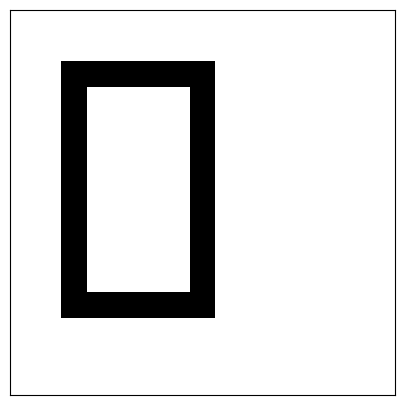

In [ ]:
def plot_matrix(matrix):
    # Plot the matrix
    plt.figure(figsize=(5,5))
    plt.imshow(matrix, cmap="gray_r", origin="upper")

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    # Show the matrix
    plt.show()

plot_matrix(generate_zero_shape_matrix(size=15, top_left=(2,2), height=10, width=6))

In [ ]:
# count total number of 1s in target
# for each 1, make it 1/(num ones)
# when you do target * mask it will be (1 * 1/(numOnes)) * numOnes which sums to 1
def compute_mask_matrix(target_matrix):
    num_ones = np.sum(target_matrix)  # Step 1: Count 1s in the matrix
    mask_matrix = np.where(target_matrix == 1, 1 / num_ones, 0)  # Step 2: Apply formula

    return mask_matrix



maskMatrix = compute_mask_matrix(matrix)
np.sum(matrix * maskMatrix)

0.9999999999999998

In [ ]:
matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
def traceNonZeroArea(matrix):
    rowIndices,colIndices = np.where(matrix != 0)

    numCols = np.sum(rowIndices == rowIndices[0])
    numRows = rowIndices[-1] - rowIndices[0]+1

    newMatrix = np.zeros((numRows, numCols))
    newRowIndices = rowIndices - rowIndices[0]
    newColIndices = colIndices - colIndices[0]

    newMatrix[newRowIndices,newColIndices] = 1
    return newMatrix

traceNonZeroArea(matrix)

array([[1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.]])

In [ ]:
def contains_submatrix(matrix, traceMatrix):
    """
    Checks if `traceMatrix` appears as a submatrix anywhere in `matrix`.

    Uses efficient NumPy operations to slide `traceMatrix` over `matrix` and find any matching region.

    Parameters:
    - matrix: The larger 2D numpy array.
    - traceMatrix: The smaller 2D numpy array to search for.

    Returns:
    - Boolean: True if `traceMatrix` exists as a submatrix within `matrix`, otherwise False.
    """
    matrix_shape = matrix.shape
    trace_shape = traceMatrix.shape

    # Ensure traceMatrix fits within matrix
    if trace_shape[0] > matrix_shape[0] or trace_shape[1] > matrix_shape[1]:
        return False

    # Create a sliding window view of the matrix - all the areas of matrix to check that are in shape of trace_matrix
    shape = (matrix_shape[0] - trace_shape[0] + 1, matrix_shape[1] - trace_shape[1] + 1) + trace_shape
    # strides tell us how much byte memory to skip to get to next col in row/next row/etc
    strides = matrix.strides + matrix.strides # doubling them tells np that first stride is for larger matrix, second for smaller matrices?
    sub_matrices = np.lib.stride_tricks.as_strided(matrix, shape=shape, strides=strides)

    # Check if any submatrix matches traceMatrix
    return np.any(np.all(sub_matrices == traceMatrix, axis=(2, 3)))

contains_submatrix(matrix, traceNonZeroArea(matrix))

True

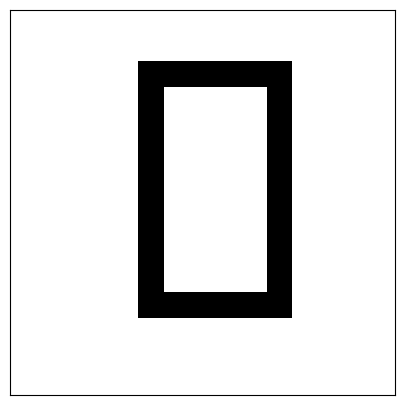

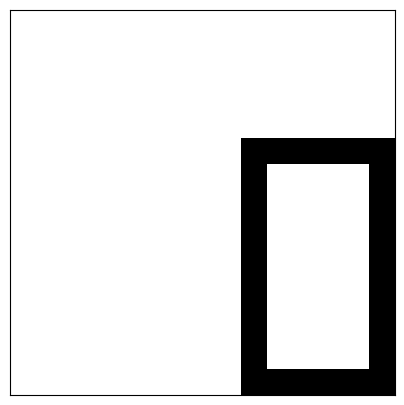

Exact match to original? 0.9999999999999998
Exact match to translated? 0.07142857142857142
Original contains submatrix? True
Translated contains submatrix? True


In [ ]:
# generate a 0 matrix
matrix = generate_zero_shape_matrix(size=15, top_left=(2,5), height=10, width=6)
translatedMatrix = generate_zero_shape_matrix(size=15, top_left=(5,9), height=10, width=6)
plot_matrix(matrix)
plot_matrix(translatedMatrix)

# generate a mask matrix - if multipled and sum then exact match
maskMatrix = compute_mask_matrix(matrix)
# generate trace matrix that only traces the area of the non zero cells
traceMatrix = traceNonZeroArea(matrix)

print(f'Exact match to original? {np.sum(matrix * maskMatrix)}')
print(f'Exact match to translated? {np.sum(translatedMatrix * maskMatrix)}')
print(f'Original contains submatrix? {contains_submatrix(matrix, traceMatrix)}')
print(f'Translated contains submatrix? {contains_submatrix(translatedMatrix, traceMatrix)}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


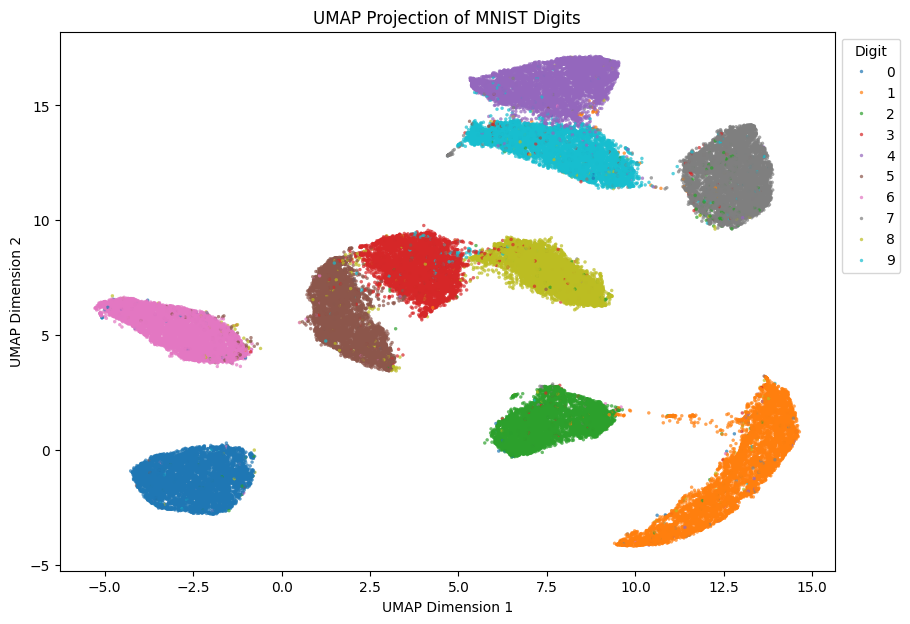

In [5]:
# Flatten images from 28x28 to 784-dim vectors
X = images.reshape(images.shape[0], -1)

# Perform PCA to reduce dimensionality before applying UMAP (best practice for speed and noise reduction)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Apply UMAP to reduce to 2D for visualization
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

# Create scatter plot of UMAP projection
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette="tab10", s=5, alpha=0.7, edgecolor=None)
plt.title("UMAP Projection of MNIST Digits")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Digit", loc="best", bbox_to_anchor=(1, 1))
plt.show()